In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import time
import matplotlib.pyplot as plt
from math import ceil

In [2]:

def QC_old(image_binary):
    QC_MCNOTs = np.count_nonzero(image_binary) * (3*(2**k)-4) 
    xgate_count = 0 
    for item in np.argwhere(image_binary[:, 0]):
        xgate_count = (np.binary_repr(item.item(), width=16).count('0') 
                       + xgate_count)
    QC_XGates = xgate_count * 0.08 * 2
    return QC_MCNOTs + QC_XGates   

def R(k):  
    R = np.array([[1, 0],
                   [1, 1]], dtype=np.uint8)
    for i in range(1,k):
        R = np.kron(R, np.array([[1, 0],
                                   [1, 1]], dtype=np.uint8))
    return R.astype(np.uint8)

def rm_concat(in1, in2):
    # concatenate two rm together : 
    # rm_concat([2], 1) = [2]
    # rm_concat([2], [0]) = [0, 2]
    if in1==1:
        return in2
    if in2==1:
        return in1
    return list(np.concatenate((in2, in1)))

def rm_kron(list2, list1):
    # kronecker product of RMs 
    # rm_kron([1,[1]], [1,[0]]) = [1, [0], [1], [0, 1]]
    output = list1
    for i in range(len(list1)):
        output.append(rm_concat(list2[1], list1[i]))
    return output

def positve_fixed_RM(k):
    # PPRM size of k
    if k==1:
        return ([1, [0]])
    if k==2:
        return rm_kron([1, [1]], [1, [0]])
    return rm_kron([1, [k-1]], positve_fixed_RM(k-1))

def mcnot_qc_1(m):
    # m: number of controls
    return 3* (2**m) - 4
def mcnot_qc_2(m):
    # m: number of controls
    if m>4:
        return 21*m - 34
    else:
        return 3* 2**m - 4

def QC(rm_dict, mcnot_mode='new'):
    cnot_sum = 0 
    xgate_sum = 0
    qc_sum = 0
    for value, key in zip(rm_dict.values(), rm_dict.keys()):
        
        for exor in value:
            if exor == 1:
                xgate_sum = xgate_sum + 1
                qc_sum = qc_sum + 0.08
                continue
                
            if len(exor)==1:
                cnot_sum = cnot_sum + 1
                qc_sum = qc_sum + 1
    
            elif len(exor) >= 2 and mcnot_mode=='old':
                qc_sum = qc_sum + mcnot_qc_1(len(exor))
            elif len(exor) >= 2 and mcnot_mode=='new':
                qc_sum = qc_sum + mcnot_qc_2(len(exor))

    return qc_sum, xgate_sum, cnot_sum

In [3]:
opt_new_file='opt_new6.csv'
opt_old_file='opt_old6.csv'
old_file='old6.csv'
# Aerial 5.1.10
# Female 4.1.04
# Moon surface 5.1.09
# Clock 5.1.12
# Airplane 5.1.11
# Jelly beans 4.1.07
address = 'sipi.usc.edu_misc/misc/4.1.07.tiff'

for dimension in range(247, 256  +1):
    image = np.array(Image.open(address).convert('L').resize((dimension, dimension)))

    image = image.astype(dtype= np.uint8)
    k = 2 * ceil(np.log2(image.shape[0]))

    image = np.pad(image, (0, 2**(k//2) - image.shape[0]))
#     plt.imshow(image, cmap='gray')
#     plt.axis('off'); plt.show()
#     print(image)

    image_binary = np.unpackbits(image.astype(np.uint8),
                                        axis=1, bitorder='big').reshape(image.shape[0]*image.shape[1],
                   8)

    time0 = time.perf_counter_ns()
    b = np.dot(R(k), image_binary).transpose().astype(np.uint8)
    # dot xor
    for i in range(b.shape[0]):
        for j in range(b.shape[1]):
            b[i][j] = b[i][j]%2

    time1= time.perf_counter_ns() - time0
    print(dimension, "\ttime1 ", time1/(10**9), " seconds")

    positve_fixed_RM_list = positve_fixed_RM(k)
    rm_dict={}
    for i in range(b.shape[0]):
        rm_list=[]
        # exor_list=[ 4  6 10 12] : idx of "1" in vector "b" 
        exor_list = np.argwhere(b[i]==1).reshape(-1)
        for idx in exor_list:
            rm_list.append(positve_fixed_RM_list[idx])
        rm_dict[i] = rm_list


    
    with open(opt_new_file, 'ab') as f:  # wb: append in row
        np.savetxt(f, [QC(rm_dict, mcnot_mode='new')[0]], fmt="%d", delimiter='\n')
    with open(opt_old_file, 'ab') as f: 
        np.savetxt(f, [QC(rm_dict, mcnot_mode='old')[0]], fmt="%d", delimiter='\n')
    with open(old_file, 'ab') as f:  
        np.savetxt(f, [QC_old(image_binary)], fmt="%d", delimiter='\n')


247 	time1  198.7844195  seconds
248 	time1  182.2058438  seconds
249 	time1  163.783485  seconds
250 	time1  157.6334823  seconds
251 	time1  164.1252299  seconds
252 	time1  165.9056902  seconds
253 	time1  168.857742  seconds
254 	time1  167.9786367  seconds
255 	time1  165.6527293  seconds
256 	time1  175.4914232  seconds


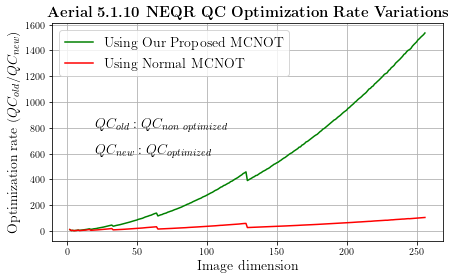

In [3]:
opt_new_file='opt_new1.csv'
opt_old_file='opt_old1.csv'
old_file='old1.csv'
dim = np.arange(2, 256 +1)

opt_new = np.loadtxt(opt_new_file)
opt_old = np.loadtxt(opt_old_file)
old = np.loadtxt(old_file)
rate_new = np.array(old)/np.array(opt_new)
rate_old = np.array(old)/np.array(opt_old)

# rate2 = np.array(y2)/np.array(x2)
# rate3 = np.array(y3)/np.array(x3)
# rate4 = np.array(y4)/np.array(x4)
# rate5 = np.array(y5)/np.array(x5)
# rate6 = np.array(y6)/np.array(x6)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif"
})

plt.plot(dim,rate_new, color='green', label=r'{Using Our Proposed MCNOT}')                       
plt.plot(dim,rate_old, color='red', label=r'{Using Normal MCNOT}')                       
# plt.plot(dim,rate2, color='red', label=r'\textbf{Female 4.1.04}')
# plt.plot(dim,rate3, color='black', label=r'\textbf{Moon surface 5.1.09}')
# plt.plot(dim,rate4, color='blue', label=r'\textbf{Clock 5.1.12}')
# plt.plot(dim,rate5, color='pink', label=r'\textbf{Airplane 5.1.11}')
# plt.plot(dim,rate6, color='yellow', label=r'\textbf{Jelly beans 4.1.07}')
plt.legend(fontsize=14)

plt.xlabel(r'{Image dimension}', fontsize=14)
plt.ylabel(r'{Optimization\ rate ($QC_{old} / QC_{new}$)}', fontsize=14)
plt.text(20, 800, r'{$QC_{old}: QC_{non\ optimized}$}', fontsize=14)
plt.text(20, 600, r'{$QC_{new}: QC_{optimized}$}', fontsize=14)
plt.title(r'\textbf{Aerial 5.1.10 NEQR\ QC\ Optimization\ Rate\ Variations}', fontsize=15)
plt.grid(axis='both')

figure = plt.gcf()
figure.set_size_inches(7, 4)
plt.savefig('graph1_1', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', format='pdf',
        transparent=False, bbox_inches=None, pad_inches=.1,
        )

plt.show()

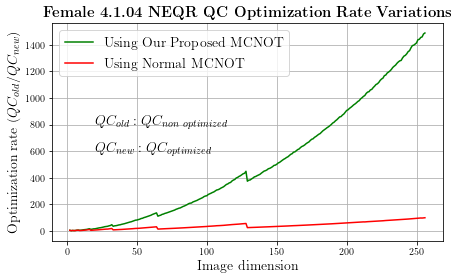

In [4]:
opt_new_file='opt_new2.csv'
opt_old_file='opt_old2.csv'
old_file='old2.csv'
dim = np.arange(2, 256 +1)

opt_new = np.loadtxt(opt_new_file)
opt_old = np.loadtxt(opt_old_file)
old = np.loadtxt(old_file)
rate_new = np.array(old)/np.array(opt_new)
rate_old = np.array(old)/np.array(opt_old)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif"
})

plt.plot(dim,rate_new, color='green', label=r'{Using Our Proposed MCNOT}')                       
plt.plot(dim,rate_old, color='red', label=r'{Using Normal MCNOT}')                  

plt.legend(fontsize=14)

plt.xlabel(r'{Image dimension}', fontsize=14)
plt.ylabel(r'{Optimization\ rate ($QC_{old} / QC_{new}$)}', fontsize=14)
plt.text(20, 800, r'{$QC_{old}: QC_{non\ optimized}$}', fontsize=14)
plt.text(20, 600, r'{$QC_{new}: QC_{optimized}$}', fontsize=14)
plt.title(r'\textbf{Female 4.1.04 NEQR\ QC\ Optimization\ Rate\ Variations}', fontsize=15)
plt.grid(axis='both')

figure = plt.gcf()
figure.set_size_inches(7, 4)
plt.savefig('graph1_2', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', format='pdf',
        transparent=False, bbox_inches=None, pad_inches=.1,
        )

plt.show()

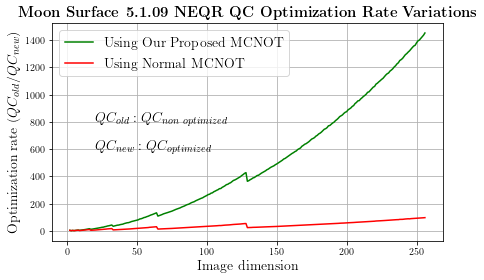

In [5]:
opt_new_file='opt_new3.csv'
opt_old_file='opt_old3.csv'
old_file='old3.csv'
dim = np.arange(2, 256 +1)

opt_new = np.loadtxt(opt_new_file)
opt_old = np.loadtxt(opt_old_file)
old = np.loadtxt(old_file)
rate_new = np.array(old)/np.array(opt_new)
rate_old = np.array(old)/np.array(opt_old)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif"
})

plt.plot(dim,rate_new, color='green', label=r'{Using Our Proposed MCNOT}')                       
plt.plot(dim,rate_old, color='red', label=r'{Using Normal MCNOT}')                 

plt.legend(fontsize=14)

plt.xlabel(r'{Image dimension}', fontsize=14)
plt.ylabel(r'{Optimization\ rate ($QC_{old} / QC_{new}$)}', fontsize=14)
plt.text(20, 800, r'{$QC_{old}: QC_{non\ optimized}$}', fontsize=14)
plt.text(20, 600, r'{$QC_{new}: QC_{optimized}$}', fontsize=14)
plt.title(r'\textbf{Moon Surface 5.1.09 NEQR\ QC\ Optimization\ Rate\ Variations}', fontsize=15)
plt.grid(axis='both')

figure = plt.gcf()
figure.set_size_inches(7, 4)
plt.savefig('graph1_3', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', format='pdf',
        transparent=False, bbox_inches=None, pad_inches=.1,
        )

plt.show()

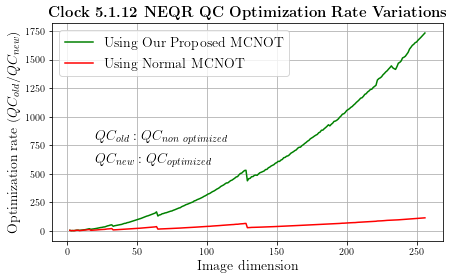

In [6]:
opt_new_file='opt_new4.csv'
opt_old_file='opt_old4.csv'
old_file='old4.csv'
dim = np.arange(2, 256 +1)

opt_new = np.loadtxt(opt_new_file)
opt_old = np.loadtxt(opt_old_file)
old = np.loadtxt(old_file)
rate_new = np.array(old)/np.array(opt_new)
rate_old = np.array(old)/np.array(opt_old)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif"
})

plt.plot(dim,rate_new, color='green', label=r'{Using Our Proposed MCNOT}')                       
plt.plot(dim,rate_old, color='red', label=r'{Using Normal MCNOT}')        

plt.legend(fontsize=14)

plt.xlabel(r'{Image dimension}', fontsize=14)
plt.ylabel(r'{Optimization\ rate ($QC_{old} / QC_{new}$)}', fontsize=14)
plt.text(20, 800, r'{$QC_{old}: QC_{non\ optimized}$}', fontsize=14)
plt.text(20, 600, r'{$QC_{new}: QC_{optimized}$}', fontsize=14)
plt.title(r'\textbf{Clock 5.1.12 NEQR\ QC\ Optimization\ Rate\ Variations}', fontsize=15)
plt.grid(axis='both')

figure = plt.gcf()
figure.set_size_inches(7, 4)
plt.savefig('graph1_4', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', format='pdf',
        transparent=False, bbox_inches=None, pad_inches=.1,
        )

plt.show()

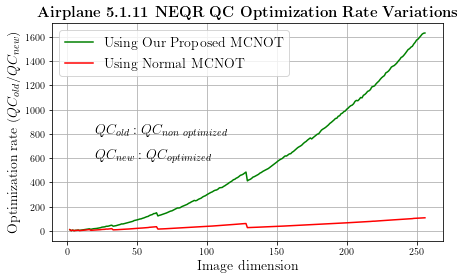

In [7]:
opt_new_file='opt_new5.csv'
opt_old_file='opt_old5.csv'
old_file='old5.csv'
dim = np.arange(2, 256 +1)

opt_new = np.loadtxt(opt_new_file)
opt_old = np.loadtxt(opt_old_file)
old = np.loadtxt(old_file)
rate_new = np.array(old)/np.array(opt_new)
rate_old = np.array(old)/np.array(opt_old)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif"
})

plt.plot(dim,rate_new, color='green', label=r'{Using Our Proposed MCNOT}')                       
plt.plot(dim,rate_old, color='red', label=r'{Using Normal MCNOT}')      

plt.legend(fontsize=14)

plt.xlabel(r'{Image dimension}', fontsize=14)
plt.ylabel(r'{Optimization\ rate ($QC_{old} / QC_{new}$)}', fontsize=14)
plt.text(20, 800, r'{$QC_{old}: QC_{non\ optimized}$}', fontsize=14)
plt.text(20, 600, r'{$QC_{new}: QC_{optimized}$}', fontsize=14)
plt.title(r'\textbf{Airplane 5.1.11 NEQR\ QC\ Optimization\ Rate\ Variations}', fontsize=15)
plt.grid(axis='both')

figure = plt.gcf()
figure.set_size_inches(7, 4)
plt.savefig('graph1_5', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', format='pdf',
        transparent=False, bbox_inches=None, pad_inches=.1,
        )

plt.show()

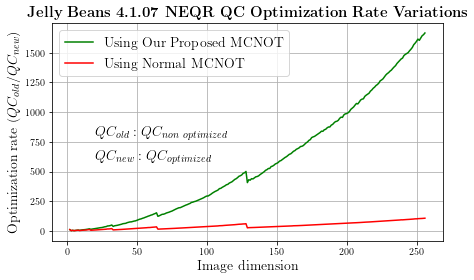

In [8]:
opt_new_file='opt_new6.csv'
opt_old_file='opt_old6.csv'
old_file='old6.csv'
dim = np.arange(2, 256 +1)

opt_new = np.loadtxt(opt_new_file)
opt_old = np.loadtxt(opt_old_file)
old = np.loadtxt(old_file)
rate_new = np.array(old)/np.array(opt_new)
rate_old = np.array(old)/np.array(opt_old)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif"
})

plt.plot(dim,rate_new, color='green', label=r'{Using Our Proposed MCNOT}')                       
plt.plot(dim,rate_old, color='red', label=r'{Using Normal MCNOT}')                  

plt.legend(fontsize=14)

plt.xlabel(r'{Image dimension}', fontsize=14)
plt.ylabel(r'{Optimization\ rate ($QC_{old} / QC_{new}$)}', fontsize=14)
plt.text(20, 800, r'{$QC_{old}: QC_{non\ optimized}$}', fontsize=14)
plt.text(20, 600, r'{$QC_{new}: QC_{optimized}$}', fontsize=14)
plt.title(r'\textbf{Jelly Beans 4.1.07 NEQR\ QC\ Optimization\ Rate\ Variations}', fontsize=15)
plt.grid(axis='both')

figure = plt.gcf()
figure.set_size_inches(7, 4)
plt.savefig('graph1_6', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', format='pdf',
        transparent=False, bbox_inches=None, pad_inches=.1,
        )

plt.show()

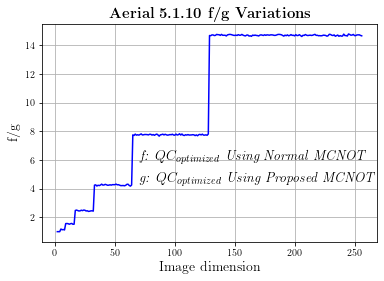

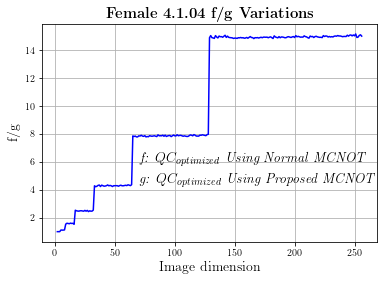

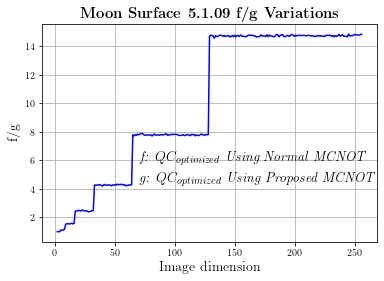

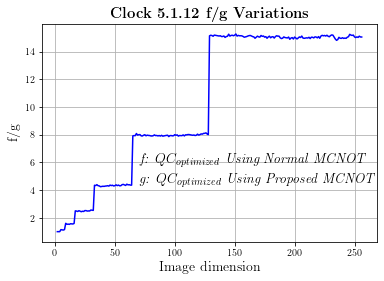

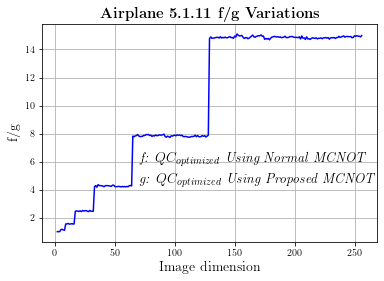

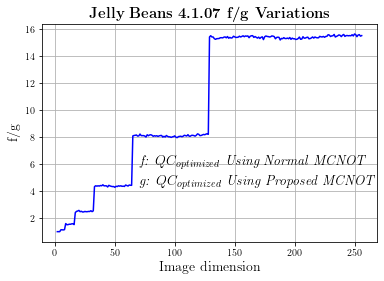

In [9]:
dim = np.arange(2, 256 +1)

opt_new_file='opt_new1.csv'
opt_old_file='opt_old1.csv'
old_file='old1.csv'

opt_new1 = np.loadtxt(opt_new_file)
opt_old1 = np.loadtxt(opt_old_file)
old1 = np.loadtxt(old_file)

opt_new_file='opt_new2.csv'
opt_old_file='opt_old2.csv'
old_file='old2.csv'

opt_new2 = np.loadtxt(opt_new_file)
opt_old2 = np.loadtxt(opt_old_file)
old2 = np.loadtxt(old_file)

opt_new_file='opt_new3.csv'
opt_old_file='opt_old3.csv'
old_file='old3.csv'

opt_new3 = np.loadtxt(opt_new_file)
opt_old3 = np.loadtxt(opt_old_file)
old3 = np.loadtxt(old_file)

opt_new_file='opt_new4.csv'
opt_old_file='opt_old4.csv'
old_file='old4.csv'

opt_new4 = np.loadtxt(opt_new_file)
opt_old4 = np.loadtxt(opt_old_file)
old4 = np.loadtxt(old_file)

opt_new_file='opt_new5.csv'
opt_old_file='opt_old5.csv'
old_file='old5.csv'

opt_new5 = np.loadtxt(opt_new_file)
opt_old5 = np.loadtxt(opt_old_file)
old5 = np.loadtxt(old_file)

opt_new_file='opt_new6.csv'
opt_old_file='opt_old6.csv'
old_file='old6.csv'

opt_new6 = np.loadtxt(opt_new_file)
opt_old6 = np.loadtxt(opt_old_file)
old6 = np.loadtxt(old_file)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif"
})
f_to_g_1 = np.array(opt_old1)/np.array(opt_new1)
f_to_g_2 = np.array(opt_old2)/np.array(opt_new2)
f_to_g_3 = np.array(opt_old3)/np.array(opt_new3)
f_to_g_4 = np.array(opt_old4)/np.array(opt_new4)
f_to_g_5 = np.array(opt_old5)/np.array(opt_new5)
f_to_g_6 = np.array(opt_old6)/np.array(opt_new6)


#############################################################   
plt.xlabel(r'{Image dimension}', fontsize=14)
plt.ylabel(r'{f/g}', fontsize=14)
plt.text(70, 6, r'\textit{f: $QC_{optimized}$ Using Normal MCNOT}', fontsize=14)
plt.text(70, 4.5, r'\textit{g: $QC_{optimized}$ Using Proposed MCNOT}', fontsize=14)
plt.title(r'\textbf{Aerial 5.1.10 f/g Variations}', fontsize=15)

plt.grid(axis='both')
plt.plot(dim,f_to_g_1, color='blue')
plt.savefig('graph2_1', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', format='pdf',
        transparent=False, bbox_inches=None, pad_inches=0.1,
        )
plt.show()


#############################################################
plt.xlabel(r'{Image dimension}', fontsize=14)
plt.ylabel(r'{f/g}', fontsize=14)
plt.text(70, 6, r'\textit{f: $QC_{optimized}$ Using Normal MCNOT}', fontsize=14)
plt.text(70, 4.5, r'\textit{g: $QC_{optimized}$ Using Proposed MCNOT}', fontsize=14)
plt.title(r'\textbf{Female 4.1.04 f/g Variations}', fontsize=15)

plt.grid(axis='both')
plt.plot(dim,f_to_g_2, color='blue')
plt.savefig('graph2_2', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', format='pdf',
        transparent=False, bbox_inches=None, pad_inches=0.1,
        )
plt.show()


#############################################################
plt.xlabel(r'{Image dimension}', fontsize=14)
plt.ylabel(r'{f/g}', fontsize=14)
plt.text(70, 6, r'\textit{f: $QC_{optimized}$ Using Normal MCNOT}', fontsize=14)
plt.text(70, 4.5, r'\textit{g: $QC_{optimized}$ Using Proposed MCNOT}', fontsize=14)
plt.title(r'\textbf{Moon Surface 5.1.09 f/g Variations}', fontsize=15)

plt.grid(axis='both')
plt.plot(dim,f_to_g_3, color='blue')
plt.savefig('graph2_3', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', format='pdf',
        transparent=False, bbox_inches=None, pad_inches=0.1,
        )
plt.show()


#############################################################
plt.xlabel(r'{Image dimension}', fontsize=14)
plt.ylabel(r'{f/g}', fontsize=14)
plt.text(70, 6, r'\textit{f: $QC_{optimized}$ Using Normal MCNOT}', fontsize=14)
plt.text(70, 4.5, r'\textit{g: $QC_{optimized}$ Using Proposed MCNOT}', fontsize=14)
plt.title(r'\textbf{Clock 5.1.12 f/g Variations}', fontsize=15)

plt.grid(axis='both')
plt.plot(dim,f_to_g_4, color='blue')
plt.savefig('graph2_4', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', format='pdf',
        transparent=False, bbox_inches=None, pad_inches=0.1,
        )
plt.show()


#############################################################
plt.xlabel(r'{Image dimension}', fontsize=14)
plt.ylabel(r'{f/g}', fontsize=14)
plt.text(70, 6, r'\textit{f: $QC_{optimized}$ Using Normal MCNOT}', fontsize=14)
plt.text(70, 4.5, r'\textit{g: $QC_{optimized}$ Using Proposed MCNOT}', fontsize=14)
plt.title(r'\textbf{Airplane 5.1.11 f/g Variations}', fontsize=15)

plt.grid(axis='both')
plt.plot(dim,f_to_g_5, color='blue')
plt.savefig('graph2_5', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', format='pdf',
        transparent=False, bbox_inches=None, pad_inches=0.1,
        )

plt.show()

#############################################################
plt.xlabel(r'{Image dimension}', fontsize=14)
plt.ylabel(r'{f/g}', fontsize=14)
plt.text(70, 6, r'\textit{f: $QC_{optimized}$ Using Normal MCNOT}', fontsize=14)
plt.text(70, 4.5, r'\textit{g: $QC_{optimized}$ Using Proposed MCNOT}', fontsize=14)
plt.title(r'\textbf{Jelly Beans 4.1.07 f/g Variations}', fontsize=15)

plt.grid(axis='both')
plt.plot(dim,f_to_g_6, color='blue')
plt.savefig('graph2_6', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', format='pdf',
        transparent=False, bbox_inches=None, pad_inches=0.1,
        )
plt.show()


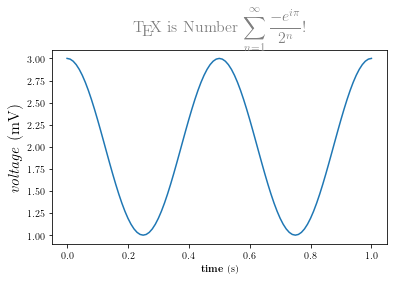

In [33]:
# Example data
t = np.arange(0.0, 1.0 + 0.01, 0.01)
s = np.cos(4 * np.pi * t) + 2

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.plot(t, s)

plt.xlabel(r'\textbf{time} (s)')
plt.ylabel(r'\textit{voltage} (mV)',fontsize=16)
plt.title(r"\TeX\ is Number "
          r"$\displaystyle\sum_{n=1}^\infty\frac{-e^{i\pi}}{2^n}$!",
          fontsize=16, color='gray')
# Make room for the ridiculously large title.
plt.subplots_adjust(top=0.8)

plt.savefig('tex_demo')
plt.show()